<a href="https://colab.research.google.com/github/BengiNouri/Project2/blob/main/Clean_ml_bdh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/new_car_data_dbh123.csv')

In [ ]:
columns_to_replace = ['GPS', 'Trailer Hitch', '4WD', 'Parkingsensor', 'Cruise Control', 'Antispin', 'ESP', 'El-SÃ¦der', 'Leather Interior', 'Glass Roof', 'Headup Display', 'Isofix', 'KlimaanlÃ¦g', 'Regnsensor', 'Soltag', 'Sports Package', 'Seatwarmer', 'Xenon Lights', 'Non-Smoker', 'One-Owner', 'Service OK', 'Nysynet', 'Demo Car', 'Partly Leather Interior', 'CVR/Engros', 'Full Leather', 'Adaptive Cruise Control']  # Specify the columns you want to replace values in
data[columns_to_replace] = data[columns_to_replace].replace({'Yes': 1, 'No': 0})

In [ ]:
#Create dummies
data = pd.get_dummies(data, columns=['Brand', 'Gear', 'Model'])


selected_features = data.columns.tolist()
# Remove the columns from our vector that are not meant to be used for modelling
selected_features.remove('Price')
selected_features.remove('Link')
selected_features.remove('Segment')


In [ ]:
p_data = data[data['Segment'] == 'Premium']


# Perform the train-test split on the Premium segment
pX_train, pX_test, py_train, py_test = train_test_split(
    p_data[selected_features],
    p_data['Price'],
    test_size=0.2,
    random_state=42
)

In [ ]:
# KNN Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(pX_train)
X_test_scaled = scaler.transform(pX_test)


knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, py_train)


predictions = knn.predict(X_test_scaled)

# Metrics
r_squared = r2_score(py_test, predictions)
mae = mean_absolute_error(py_test, predictions)
rmse = np.sqrt(mean_squared_error(py_test, predictions))

# Print the performance metrics
print(f"R² Score: {r_squared}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

R² Score: 0.5612841194327409
Mean Absolute Error: 47368.634456928834
Root Mean Squared Error: 68687.59783647167


In [ ]:
# Baseline xgboosting without parameters # 6 sec
xgb_model = XGBRegressor(n_estimators=600)
xgb_model.fit(pX_train, py_train)
predictions_xgb = xgb_model.predict(pX_test)

#Metrics
r_squared = r2_score(py_test, predictions_xgb)
mae = mean_absolute_error(py_test, predictions_xgb)
mse = mean_squared_error(py_test, predictions_xgb)
rmse = np.sqrt(mse)
#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': pX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))

R-squared: 0.7451715282341684
Mean Absolute Error: 35684.27577832397
Mean Squared Error: 2740446015.403927
Root Mean Squared Error: 52349.26948300164
Top 25 important features:
              Feature  Importance
31         Horsepower    0.080246
51     Brand_Mercedes    0.054576
35   Fuel_Type_Hybrid    0.051691
253  Model_California    0.033929
336      Model_GLB200    0.023383
33   Fuel_Type_Diesel    0.022148
547        Model_V250    0.020328
349     Model_GLE350e    0.018884
30               Year    0.018267
28       Full Leather    0.018209
546        Model_V220    0.017959
573        Model_XC60    0.017495
560        Model_Vito    0.017010
62           Brand_VW    0.016653
108        Model_330e    0.016064
116         Model_420    0.014709
463          Model_Q7    0.014496
274     Model_Corolla    0.013554
593      Model_e-tron    0.012813
486        Model_S350    0.012550
38          Brand_BMW    0.012212
551         Model_V60    0.012124
570          Model_X5    0.011893
386    

In [ ]:
# XGBoosting with hyperparameters # 32 min

# Defining grid
param_grid = {
        'min_child_weight': [5, 10],
        'gamma': [0, 2],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 8, 12]
        }

xgb_model = XGBRegressor(n_estimators=600)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=0)
grid_search.fit(pX_train, py_train)
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
predictions = best_model.predict(pX_test)

#Metrics
r_squared = r2_score(py_test, predictions)
mae = mean_absolute_error(py_test, predictions)
mse = mean_squared_error(py_test, predictions)
rmse = np.sqrt(mse)
#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': pX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))

Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}
R-squared: 0.7034094972120637
Mean Absolute Error: 37879.21582397004
Mean Squared Error: 3189558277.925635
Root Mean Squared Error: 56476.174427147904
Top 25 important features:
            Feature  Importance
31       Horsepower    0.057783
593    Model_e-tron    0.046401
161        Model_A5    0.045533
4               4WD    0.035738
570        Model_X5    0.034067
336    Model_GLB200    0.033415
116       Model_420    0.030071
11       Glass Roof    0.029955
51   Brand_Mercedes    0.026745
349   Model_GLE350e    0.026405
18   Sports Package    0.026117
108      Model_330e    0.018126
6    Cruise Control    0.016017
12   Headup Display    0.016002
573      Model_XC60    0.015947
386    Model_Kodiaq    0.015285
30             Year    0.014559
21       Non-Smoker    0.014358
162        Model_A6    0.013764
1              Km/L    0.013606
540    Model_Touran    0.012800
551   

Random Forest Regression Model Evaluation:
R-squared: 0.7186062713786522
Mean Absolute Error: 37048.001727255614
Mean Squared Error: 3026130938.25972
Root Mean Squared Error: 55010.280296138466
Top 25 important features:
                     Feature  Importance
31                Horsepower    0.406094
1                       Km/L    0.096224
30                      Year    0.081568
0                  KM Driven    0.075806
51            Brand_Mercedes    0.015681
12            Headup Display    0.011831
11                Glass Roof    0.010427
336             Model_GLB200    0.009879
18            Sports Package    0.008672
3              Trailer Hitch    0.008663
546               Model_V220    0.007907
4                        4WD    0.007786
349            Model_GLE350e    0.007664
116                Model_420    0.007601
6             Cruise Control    0.007489
16                Regnsensor    0.006985
547               Model_V250    0.006851
13                    Isofix    0.006787


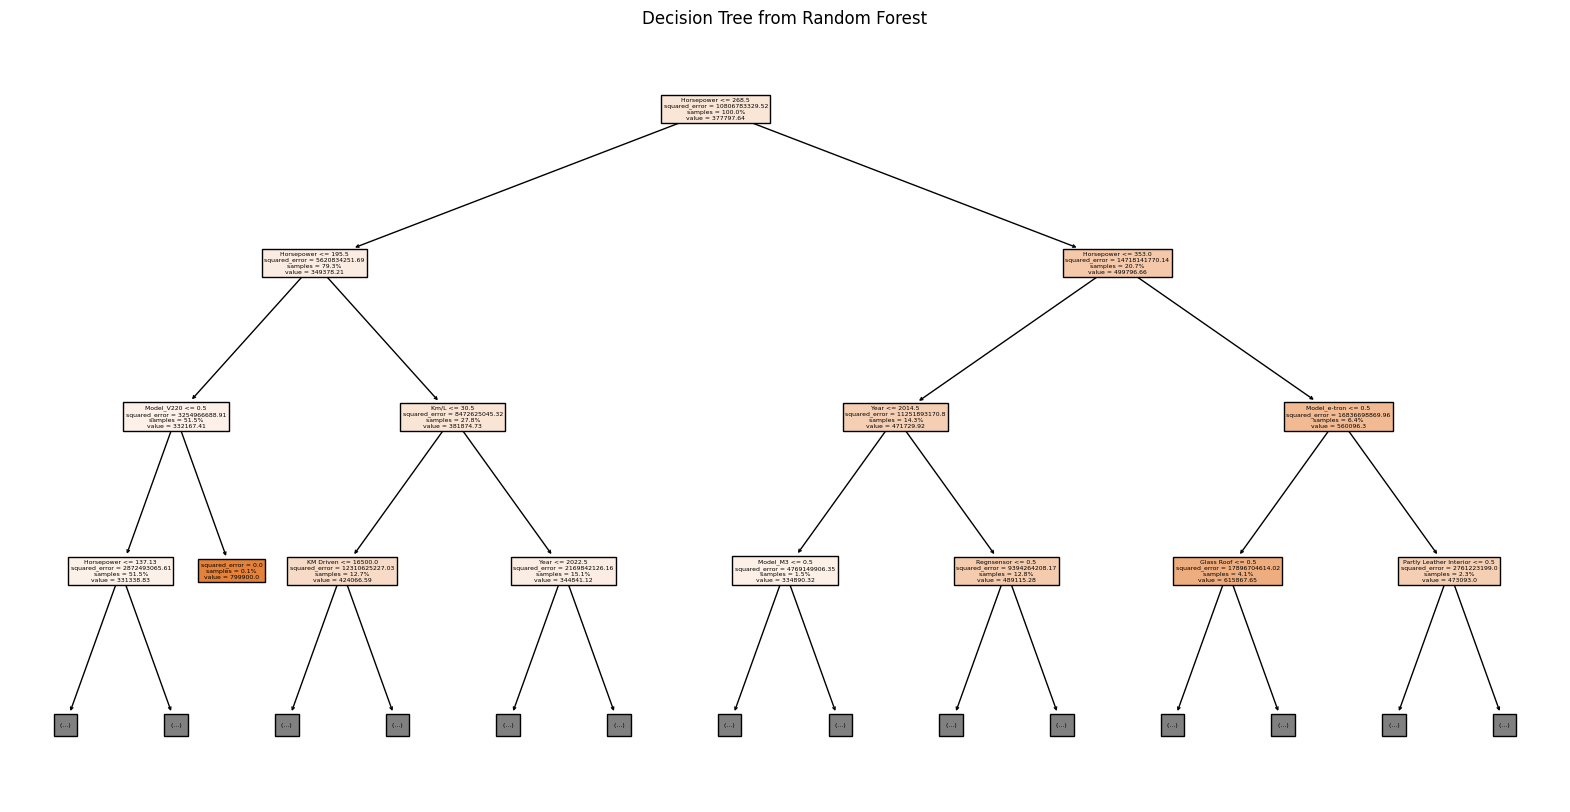

In [ ]:
# Random Forest # 2 min
rf_model = RandomForestRegressor(n_estimators=600, random_state=42)


rf_model.fit(pX_train, py_train)
rpredictions = rf_model.predict(pX_test)

# Metrics
rr_squared = r2_score(py_test, rpredictions)
rmae = mean_absolute_error(py_test, rpredictions)
rmse = mean_squared_error(py_test, rpredictions)
rrmse = np.sqrt(rmse)

print("Random Forest Regression Model Evaluation:")
print("R-squared:", rr_squared)
print("Mean Absolute Error:", rmae)
print("Mean Squared Error:", rmse)
print("Root Mean Squared Error:", rrmse)

# Feature Importance For Random Forest
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': pX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25
print("Top", N, "important features:")
print(feature_importance_df.head(N))


tree = rf_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=pX_train.columns, max_depth=3, precision=2, proportion=True)
plt.title('Decision Tree from Random Forest')
plt.show()


In [ ]:
# Linear regressionsmodel # 1 sec
l_features = ['KM Driven', 'Year', 'Horsepower', 'Km/L', 'Gear_Automatgear', 'Fuel_Type_Diesel', 'Adaptive Cruise Control']
lX_train, lX_test, ly_train, ly_test = train_test_split(p_data[l_features], p_data['Price'], test_size=0.2, random_state=42)

linear_model = LinearRegression()


linear_model.fit(lX_train, ly_train)

linear_predictions = linear_model.predict(lX_test)

# Metrics
linear_r_squared = r2_score(ly_test, linear_predictions)
linear_mae = mean_absolute_error(ly_test, linear_predictions)
linear_mse = mean_squared_error(ly_test, linear_predictions)
linear_rmse = np.sqrt(linear_mse)

print("Linear Regression Model Evaluation:")
print("R-squared:", linear_r_squared)
print("Mean Absolute Error:", linear_mae)
print("Mean Squared Error:", linear_mse)
print("Root Mean Squared Error:", linear_rmse)

Linear Regression Model Evaluation:
R-squared: 0.42326960919210965
Mean Absolute Error: 58517.53431316649
Mean Squared Error: 6202205312.851356
Root Mean Squared Error: 78754.0812456812


In [ ]:
m_data = data[data['Segment'] == 'Mid-Range']


# Perform the train-test split on the Mid-Range segment
mX_train, mX_test, my_train, my_test = train_test_split(
    m_data[selected_features],
    m_data['Price'],
    test_size=0.2,
    random_state=42
)

In [ ]:
# KNN Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(mX_train)
X_test_scaled = scaler.transform(mX_test)


knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, my_train)


predictions = knn.predict(X_test_scaled)

# Metrics
r_squared = r2_score(my_test, predictions)
mae = mean_absolute_error(my_test, predictions)
rmse = np.sqrt(mean_squared_error(my_test, predictions))

# Print the performance metrics
print(f"R² Score: {r_squared}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

R² Score: 0.2830787607137081
Mean Absolute Error: 23500.62255639098
Root Mean Squared Error: 29217.41485161963


In [ ]:
# Baseline xgboosting without parameters # 6 sec
xgb_model = XGBRegressor(n_estimators=600)
xgb_model.fit(mX_train, my_train)
predictions_xgb = xgb_model.predict(mX_test)

#Metrics
r_squared = r2_score(my_test, predictions_xgb)
mae = mean_absolute_error(my_test, predictions_xgb)
mse = mean_squared_error(my_test, predictions_xgb)
rmse = np.sqrt(mse)
#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': mX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))

R-squared: 0.6388921634469411
Mean Absolute Error: 15611.962892722879
Mean Squared Error: 429980777.4166526
Root Mean Squared Error: 20735.97785050545
Top 25 important features:
                     Feature  Importance
596                 Model_i3    0.078057
55                Brand_Opel    0.033254
51            Brand_Mercedes    0.029510
536             Model_Tiguan    0.023890
31                Horsepower    0.021647
57             Brand_Renault    0.020374
381              Model_Kamiq    0.017860
181              Model_Ateca    0.015304
30                      Year    0.014580
123               Model_5008    0.014230
523             Model_Superb    0.013888
384              Model_Karoq    0.013506
58                Brand_Seat    0.013344
56             Brand_Peugeot    0.013018
64          Gear_Automatgear    0.012923
44                Brand_Ford    0.012422
48                 Brand_Kia    0.012201
369              Model_Ibiza    0.011925
43                Brand_Fiat    0.011476
54

In [ ]:
# XGBoosting with hyperparameters # 32 min

# Defining grid
param_grid = {
        'min_child_weight': [5, 10],
        'gamma': [0, 2],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 8, 12]
        }

xgb_model = XGBRegressor(n_estimators=600)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=0)
grid_search.fit(mX_train, my_train)
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
predictions = best_model.predict(mX_test)

#Metrics
r_squared = r2_score(my_test, predictions)
mae = mean_absolute_error(my_test, predictions)
mse = mean_squared_error(my_test, predictions)
rmse = np.sqrt(mse)

#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': mX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25
print("Top", N, "important features:")
print(feature_importance_df.head(N))

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}
R-squared: 0.6269579748995393
Mean Absolute Error: 15577.61978047798
Mean Squared Error: 444191135.5147515
Root Mean Squared Error: 21075.842462752265
Top 25 important features:
                     Feature  Importance
439             Model_Optima    0.068184
64          Gear_Automatgear    0.039623
51            Brand_Mercedes    0.034728
596                 Model_i3    0.034288
31                Horsepower    0.029304
536             Model_Tiguan    0.025609
55                Brand_Opel    0.023730
57             Brand_Renault    0.021785
30                      Year    0.021751
381              Model_Kamiq    0.018286
29   Adaptive Cruise Control    0.017303
4                        4WD    0.016481
162                 Model_A6    0.015194
58                Brand_Seat    0.014907
384              Model_Karoq    0.014586
10          Leather Interior    0.014175
26   Partly L

Random Forest Regression Model Evaluation:
R-squared: 0.6072328497028421
Mean Absolute Error: 16794.727353196507
Mean Squared Error: 467678370.65114677
Root Mean Squared Error: 21625.87271420848
Top 25 important features:
                     Feature  Importance
31                Horsepower    0.238819
0                  KM Driven    0.165443
30                      Year    0.135845
1                       Km/L    0.049422
64          Gear_Automatgear    0.017611
65         Gear_Manuelt gear    0.017235
51            Brand_Mercedes    0.011938
596                 Model_i3    0.009281
29   Adaptive Cruise Control    0.008707
10          Leather Interior    0.008099
57             Brand_Renault    0.008075
6             Cruise Control    0.007989
540             Model_Touran    0.007626
24                   Nysynet    0.007569
16                Regnsensor    0.007015
3              Trailer Hitch    0.006927
22                 One-Owner    0.006882
7                   Antispin    0.006834

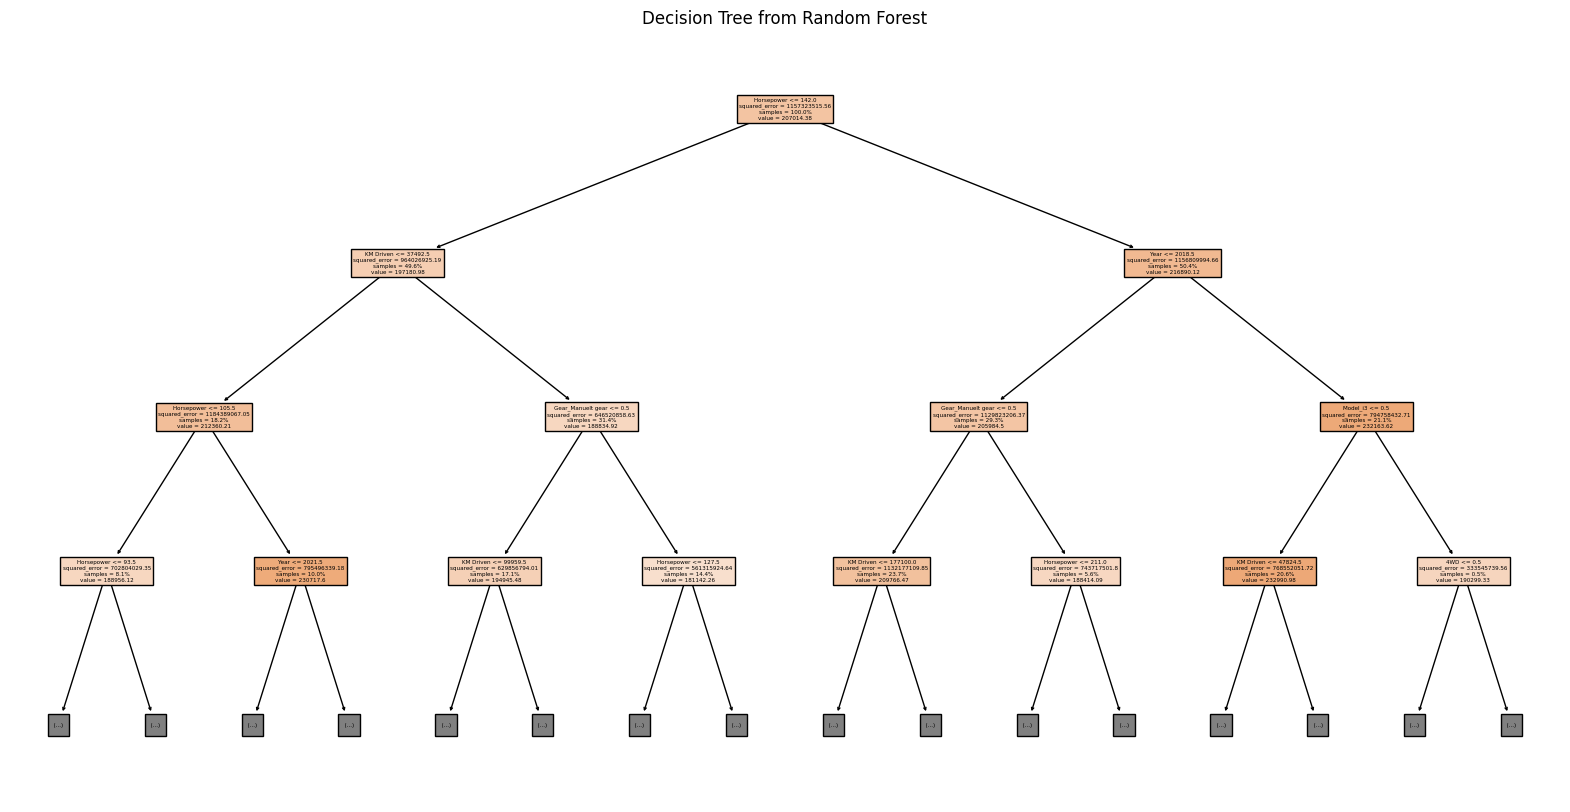

In [ ]:
# Random Forest # 2 min
rf_model = RandomForestRegressor(n_estimators=600, random_state=42)


rf_model.fit(mX_train, my_train)


rpredictions = rf_model.predict(mX_test)

# Metrics
rr_squared = r2_score(my_test, rpredictions)
rmae = mean_absolute_error(my_test, rpredictions)
rmse = mean_squared_error(my_test, rpredictions)
rrmse = np.sqrt(rmse)

print("Random Forest Regression Model Evaluation:")
print("R-squared:", rr_squared)
print("Mean Absolute Error:", rmae)
print("Mean Squared Error:", rmse)
print("Root Mean Squared Error:", rrmse)

# Feature Importance For Random Forest
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': mX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25
print("Top", N, "important features:")
print(feature_importance_df.head(N))

tree = rf_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=mX_train.columns, max_depth=3, precision=2, proportion=True)
plt.title('Decision Tree from Random Forest')
plt.show()

In [ ]:
# Linear regressionsmodel # 1 sec
l_features = ['KM Driven', 'Year', 'Horsepower', 'Km/L', 'Gear_Automatgear', 'Fuel_Type_Diesel', 'Adaptive Cruise Control']
lX_train, lX_test, ly_train, ly_test = train_test_split(m_data[l_features], m_data['Price'], test_size=0.2, random_state=42)

linear_model = LinearRegression()

linear_model.fit(lX_train, ly_train)

linear_predictions = linear_model.predict(lX_test)

# Metrics
linear_r_squared = r2_score(ly_test, linear_predictions)
linear_mae = mean_absolute_error(ly_test, linear_predictions)
linear_mse = mean_squared_error(ly_test, linear_predictions)
linear_rmse = np.sqrt(linear_mse)

print("Linear Regression Model Evaluation:")
print("R-squared:", linear_r_squared)
print("Mean Absolute Error:", linear_mae)
print("Mean Squared Error:", linear_mse)
print("Root Mean Squared Error:", linear_rmse)

Linear Regression Model Evaluation:
R-squared: 0.3427438178922799
Mean Absolute Error: 22914.187080561358
Mean Squared Error: 782612548.2132924
Root Mean Squared Error: 27975.21310398354


In [ ]:
e_data = data[data['Segment'] == 'Economy']


# Perform the train-test split on the Economy segment
eX_train, eX_test, ey_train, ey_test = train_test_split(
    e_data[selected_features],
    e_data['Price'],
    test_size=0.2,
    random_state=42
)

In [ ]:
# KNN Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(eX_train)
X_test_scaled = scaler.transform(eX_test)

knn = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train_scaled, ey_train)
predictions = knn.predict(X_test_scaled)

# Metrics
r_squared = r2_score(ey_test, predictions)
mae = mean_absolute_error(ey_test, predictions)
rmse = np.sqrt(mean_squared_error(ey_test, predictions))

# Print the performance metrics
print(f"R² Score: {r_squared}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

R² Score: 0.4835269672550593
Mean Absolute Error: 22323.78293577982
Root Mean Squared Error: 28299.662357484638


In [ ]:
# Baseline xgboosting without parameters # 6 sec
xgb_model = XGBRegressor(n_estimators=600)
xgb_model.fit(eX_train, ey_train)
predictions_xgb = xgb_model.predict(eX_test)

#Metrics
r_squared = r2_score(ey_test, predictions_xgb)
mae = mean_absolute_error(ey_test, predictions_xgb)
mse = mean_squared_error(ey_test, predictions_xgb)
rmse = np.sqrt(mse)

#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': eX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25
print("Top", N, "important features:")
print(feature_importance_df.head(N))

R-squared: 0.801011309333901
Mean Absolute Error: 12559.395699485289
Mean Squared Error: 308562576.55252886
Root Mean Squared Error: 17565.949349594768
Top 25 important features:
              Feature  Importance
30               Year    0.055768
329        Model_G350    0.053003
31         Horsepower    0.030505
62           Brand_VW    0.029069
346       Model_GLC63    0.024085
51     Brand_Mercedes    0.021883
37         Brand_Audi    0.021279
38          Brand_BMW    0.020742
287      Model_Dokker    0.020570
64   Gear_Automatgear    0.018177
286      Model_DoblÃ²    0.016741
465     Model_Qashqai    0.012362
55         Brand_Opel    0.012077
40     Brand_CitroÃ«n    0.011859
413         Model_MX5    0.011692
559      Model_Vitara    0.011247
39    Brand_Chevrolet    0.010973
579         Model_XJ6    0.010863
393        Model_Land    0.010764
124        Model_500C    0.010638
14        KlimaanlÃ¦g    0.010404
42        Brand_Dacia    0.009390
4                 4WD    0.009307
21   

In [ ]:
# XGBoosting with hyperparameters # 32 min

# Defining grid
param_grid = {
        'min_child_weight': [5, 10],
        'gamma': [0, 2],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 1.0],
        'max_depth': [3, 8, 12]
        }

xgb_model = XGBRegressor(n_estimators=600)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=0)
grid_search.fit(eX_train, ey_train)
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
predictions = best_model.predict(eX_test)

#Metrics
r_squared = r2_score(ey_test, predictions)
mae = mean_absolute_error(ey_test, predictions)
mse = mean_squared_error(ey_test, predictions)
rmse = np.sqrt(mse)
#Print Metrics
print("R-squared:", r_squared)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Feature Importance
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': eX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25  # Number of Features
print("Top", N, "important features:")
print(feature_importance_df.head(N))

Best Parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}
R-squared: 0.8205079769002839
Mean Absolute Error: 12070.831195348337
Mean Squared Error: 278329994.19655013
Root Mean Squared Error: 16683.22493394338
Top 25 important features:
                     Feature  Importance
30                      Year    0.068970
64          Gear_Automatgear    0.052979
29   Adaptive Cruise Control    0.035478
31                Horsepower    0.033096
62                  Brand_VW    0.031301
16                Regnsensor    0.026909
59               Brand_Skoda    0.025714
287             Model_Dokker    0.023973
14               KlimaanlÃ¦g    0.022953
21                Non-Smoker    0.020921
40            Brand_CitroÃ«n    0.020406
0                  KM Driven    0.018717
413                Model_MX5    0.016389
465            Model_Qashqai    0.015701
38                 Brand_BMW    0.013368
6             Cruise Control    0.013167
124         

Random Forest Regression Model Evaluation:
R-squared: 0.795842249855753
Mean Absolute Error: 13070.65317766128
Mean Squared Error: 316577998.4621436
Root Mean Squared Error: 17792.638884160595
Top 25 important features:
              Feature  Importance
30               Year    0.450511
31         Horsepower    0.220095
0           KM Driven    0.111204
1                Km/L    0.022721
5       Parkingsensor    0.006781
64   Gear_Automatgear    0.006658
3       Trailer Hitch    0.006559
62           Brand_VW    0.006340
65  Gear_Manuelt gear    0.006214
14        KlimaanlÃ¦g    0.005434
13             Isofix    0.005385
6      Cruise Control    0.004040
24            Nysynet    0.003951
28       Full Leather    0.003888
8                 ESP    0.003826
7            Antispin    0.003572
25           Demo Car    0.003525
16         Regnsensor    0.003401
2                 GPS    0.003158
19         Seatwarmer    0.003000
9           El-SÃ¦der    0.002979
51     Brand_Mercedes    0.00294

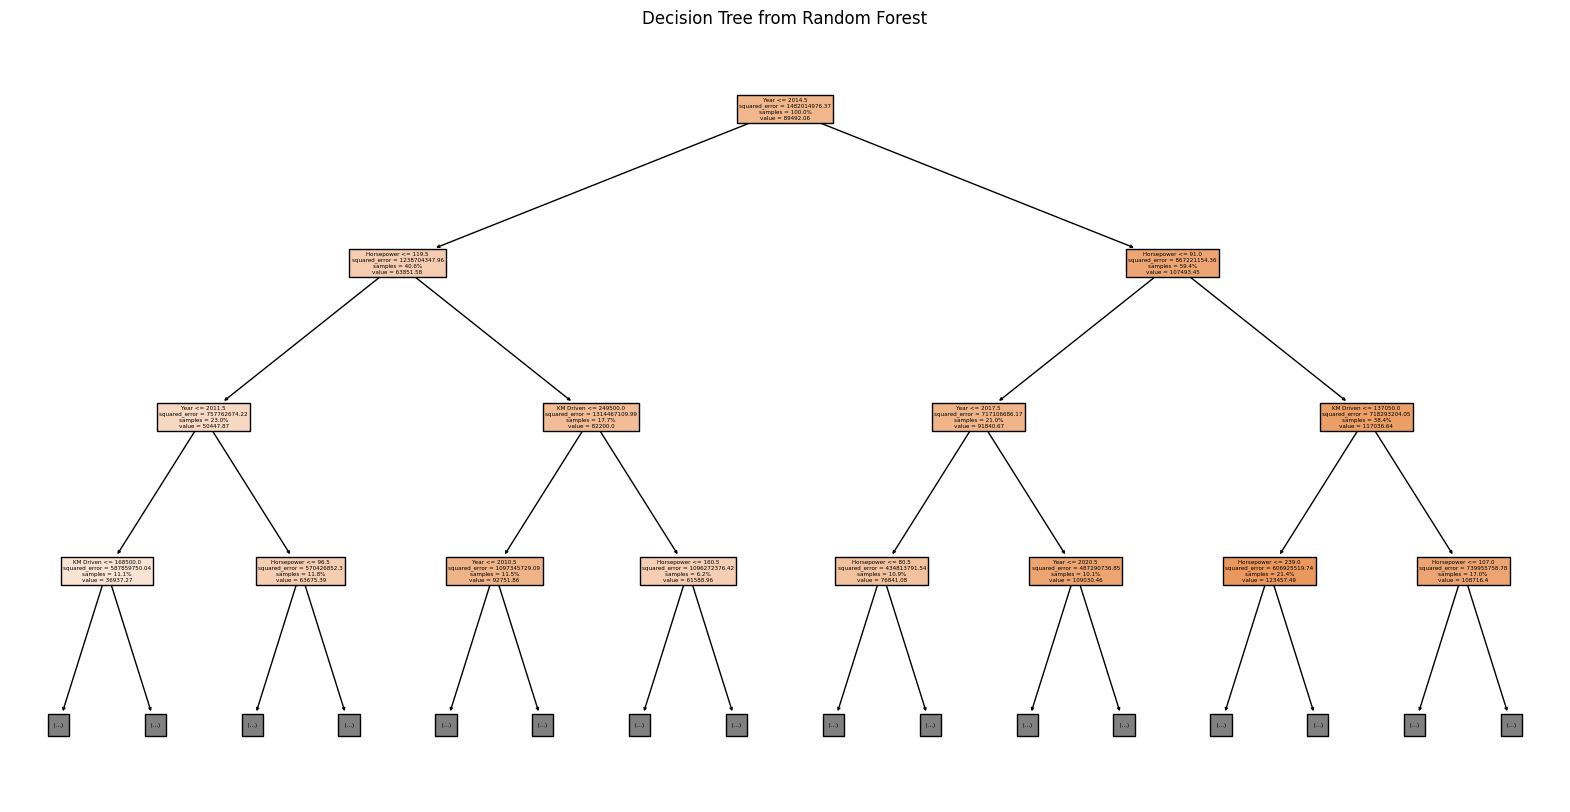

In [ ]:
# Random Forest # 2 min
rf_model = RandomForestRegressor(n_estimators=600, random_state=42)

rf_model.fit(eX_train, ey_train)

rpredictions = rf_model.predict(eX_test)

rr_squared = r2_score(ey_test, rpredictions)
rmae = mean_absolute_error(ey_test, rpredictions)
rmse = mean_squared_error(ey_test, rpredictions)
rrmse = np.sqrt(rmse)

print("Random Forest Regression Model Evaluation:")
print("R-squared:", rr_squared)
print("Mean Absolute Error:", rmae)
print("Mean Squared Error:", rmse)
print("Root Mean Squared Error:", rrmse)

# Feature Importance For Random Forest
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': eX_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
N = 25
print("Top", N, "important features:")
print(feature_importance_df.head(N))

tree = rf_model.estimators_[0]

# Plot the tree
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=eX_train.columns, max_depth=3, precision=2, proportion=True)
plt.title('Decision Tree from Random Forest')
plt.show()


In [ ]:
# Linear regressionsmodel # 1 sec
l_features = ['KM Driven', 'Year', 'Horsepower', 'Km/L', 'Gear_Automatgear', 'Fuel_Type_Diesel', 'Adaptive Cruise Control']
lX_train, lX_test, ly_train, ly_test = train_test_split(e_data[l_features], e_data['Price'], test_size=0.2, random_state=42)

linear_model = LinearRegression()


linear_model.fit(lX_train, ly_train)

linear_predictions = linear_model.predict(lX_test)

# Metrics
linear_r_squared = r2_score(ly_test, linear_predictions)
linear_mae = mean_absolute_error(ly_test, linear_predictions)
linear_mse = mean_squared_error(ly_test, linear_predictions)
linear_rmse = np.sqrt(linear_mse)

print("Linear Regression Model Evaluation:")
print("R-squared:", linear_r_squared)
print("Mean Absolute Error:", linear_mae)
print("Mean Squared Error:", linear_mse)
print("Root Mean Squared Error:", linear_rmse)

Linear Regression Model Evaluation:
R-squared: 0.5262562958299793
Mean Absolute Error: 21452.279179617617
Mean Squared Error: 734612492.2723794
Root Mean Squared Error: 27103.7357622963
